# Imports

In [1]:
import sys
sys.path.insert(1, '../')
from genesis import *

C:\Users\vin_s\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
universe = [x for x in ASIA_FX if x not in ["USDMYR", "USDCNH"]]
total_returns = total_returns_usd[universe]
spot_returns = spot_returns_usd[universe]
carry_returns = carry_returns_usd[universe]

# Settings

In [3]:
settings = Settings(start_date = "2000-01-01", end_date = "2016-12-31", notional = 100, implementation_lag = 1,
                   asset_scaling_method="simple", asset_scaling_target=0.1, asset_scaling_width=130, rebalance_period="daily",
                   sector_scaling_method="simple", sector_scaling_target=0.1, sector_scaling_width=130,
                   portfolio_scaling_method="simple", portfolio_scaling_target=0.1, portfolio_scaling_width=260)

# Other Data

In [61]:
reer_ppi = read_prices("../../Dymon/Code Data/REER_PPI.csv")

In [62]:
reer_ppi.columns = [x[0] for x in reer_ppi.columns]

In [63]:
asia_reer_ppi = reer_ppi[[("JBDP"+x+" Index") for x in [x[3:] for x in universe]]]
asia_reer_ppi.columns = universe

In [64]:
asia_reer_ppi_cleaned = asia_reer_ppi.pipe(fill_date, True).pipe(omit_trailing_na)

# Data Integrity

<AxesSubplot:>

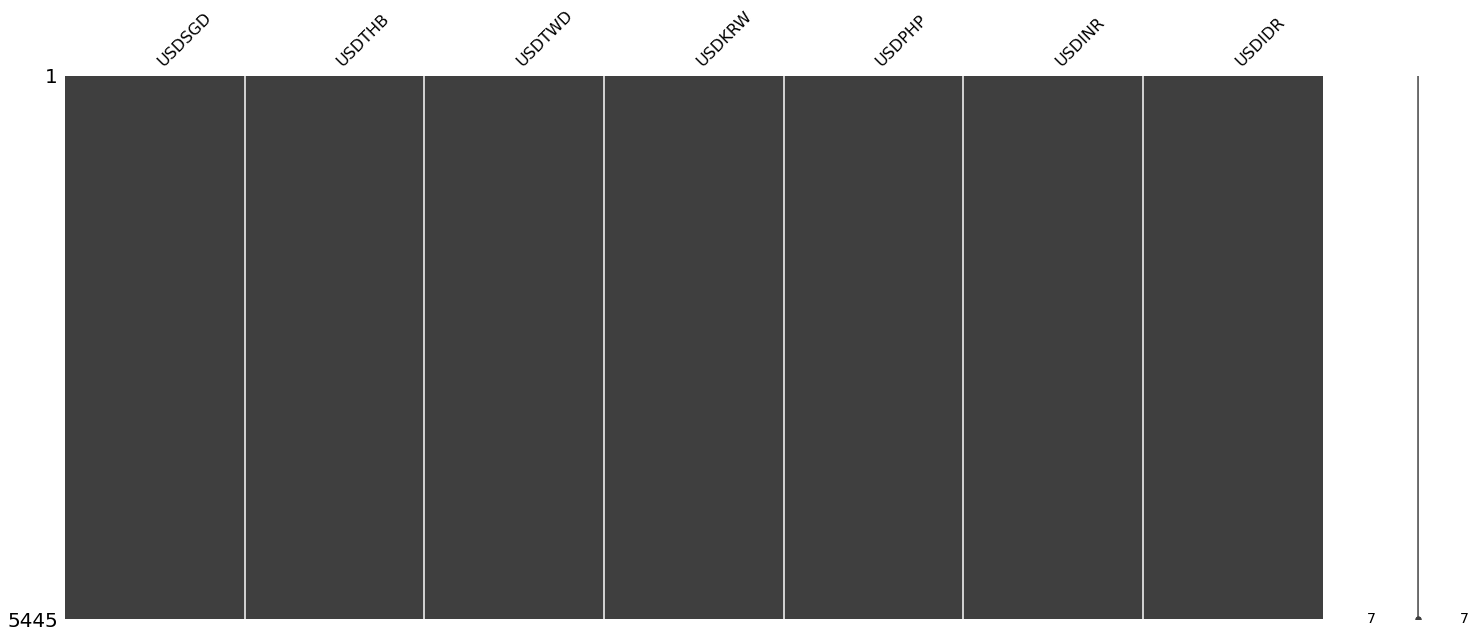

In [65]:
msmx(asia_reer_ppi)

# Signal 

In [66]:
mag = asia_reer_ppi_cleaned.pipe(demean_pct, 252*5, 252)
sig = abs(mag) * mag.pipe(omit_leading_na,"any").pipe(high_minus_low) * -1

# Backtest Daily Rebal

In [67]:
daily_bt = Backtest(signal = sig, 
                    asset_returns = total_returns, 
                    tcost = abs(total_returns*0), 
                    settings = settings,
                    settings_inject={"use_cov":False})
daily_bt.run()

Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


In [68]:
get_summary(daily_bt)

Returns   : -0.05620571048461567
Vol       : 0.1138562641796017
SR        : -0.49365496830244143
Max DD    : -111.61

C Returns : -0.06076141860977586
C SR      : -0.534765783201099
C Max DD  : -69.03

Hit rate  : 0.466
W | N | L : 0.47 | 0.0 | 0.53
W/L Ratio : 0.87


In [69]:
get_returns_stats(daily_bt.asset_rtn, daily_bt.wts)

,USDSGD,USDTHB,USDTWD,USDKRW,USDPHP,USDINR,USDIDR
annualized_return,-0.269204,-3.069887,0.719615,0.192185,-2.592059,0.388964,-1.645843
sharpe,-0.052002,-0.557432,0.42052,0.031442,-0.453949,0.24191,-0.205695
dollar_sharpe,-0.072539,-0.648439,0.406933,0.001008,-0.513149,0.239568,-0.241526
trade_sharpe,-0.306968,-1.412788,0.68018,-0.034222,-0.71643,0.38265,-0.447432
long_sharpe,-1.161555,-1.412788,NaN,0.116059,-2.27993,-4.308033,-0.461469
short_sharpe,-0.279263,NaN,0.68018,-0.190358,0.304205,0.506085,0.096021
sortino,-0.018019,-0.135662,0.155417,0.013989,-0.182986,0.034458,-0.112089
max_drawdown,-25.482131,-68.800332,-5.834167,-26.479055,-49.138643,-3.31737,-32.438312
max_drawdown_start,2012-08-29,2007-02-12,2005-01-13,2002-04-25,2001-07-03,2013-08-20,2002-04-09
max_drawdown_end,2016-01-08,2013-04-19,2005-11-04,2008-10-08,2014-01-21,2013-09-03,2016-09-27


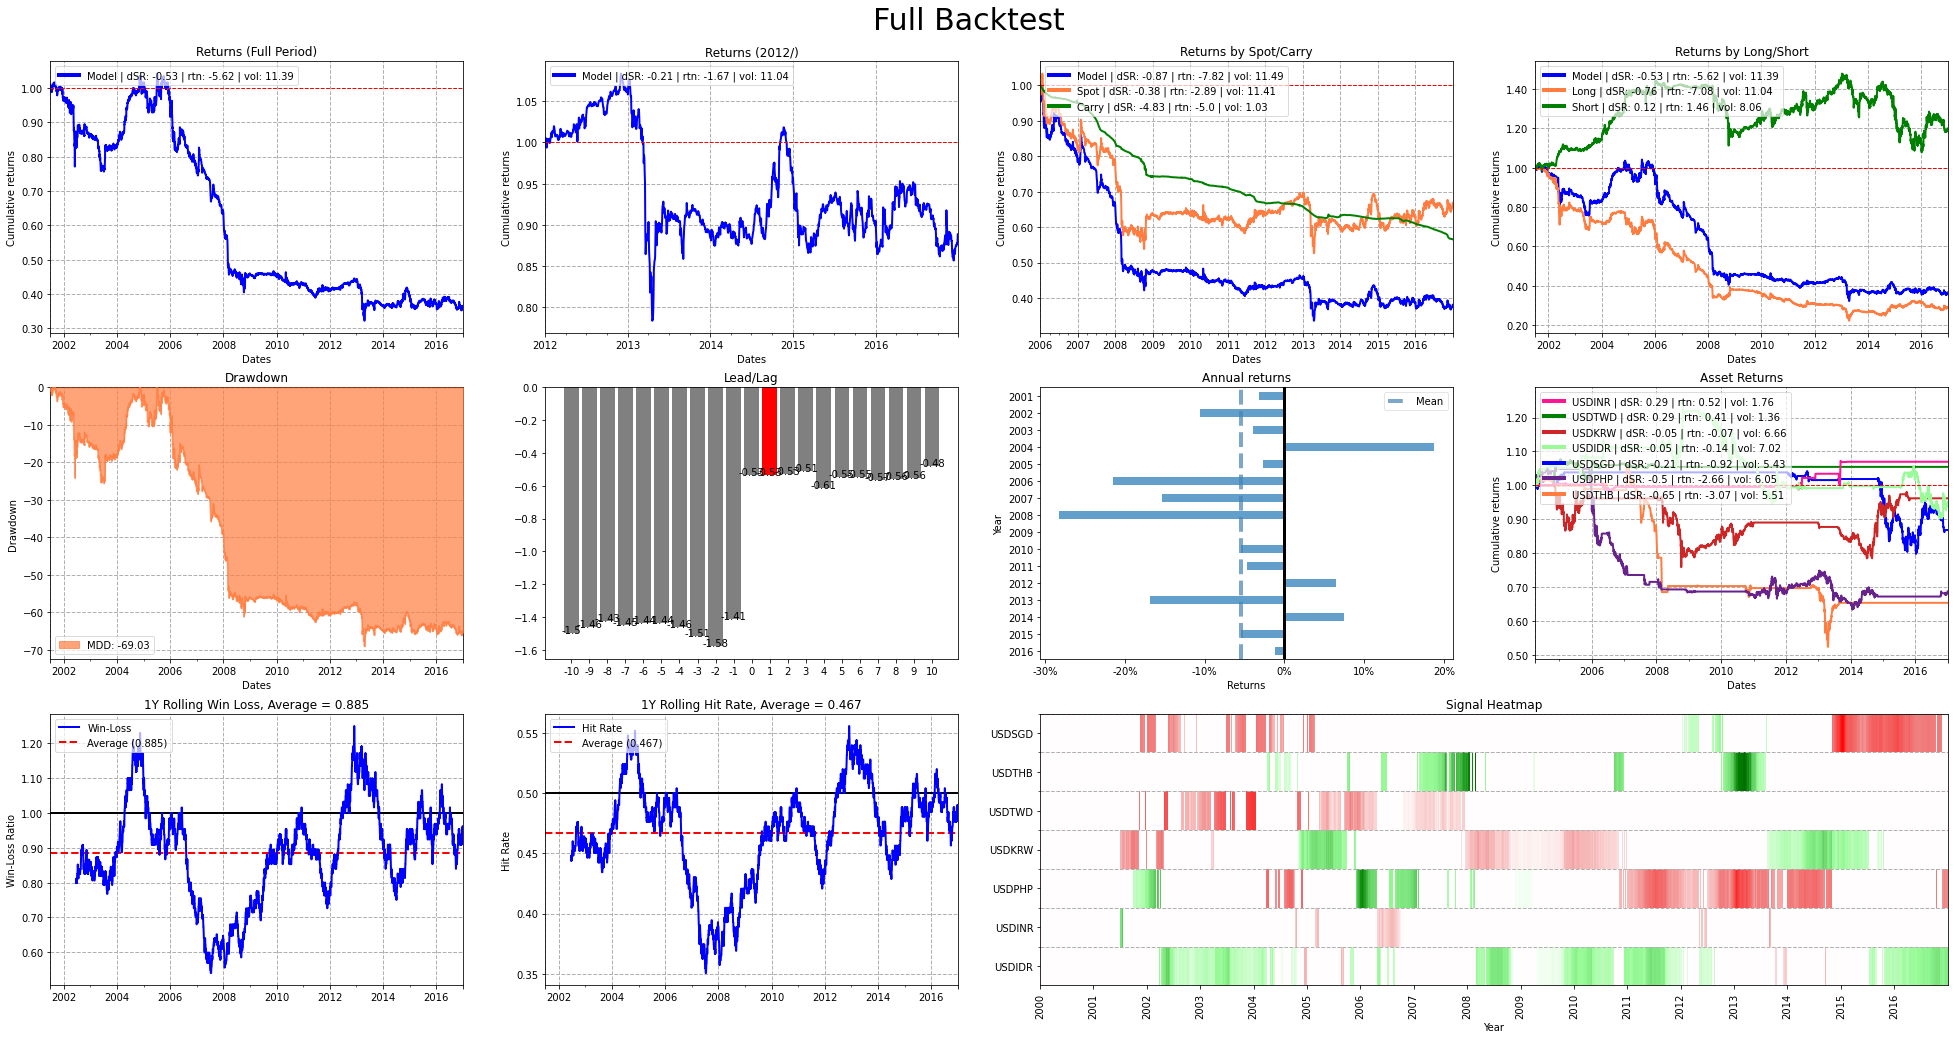

In [70]:
plot_bt(daily_bt)

# Backtest Other Freq

Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Re-arranging asset columns
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]
Asset scaling ...
Portfolio scaling ...
    Grouping by [ALL]


<AxesSubplot:xlabel='Dates', ylabel='Cumulative returns'>

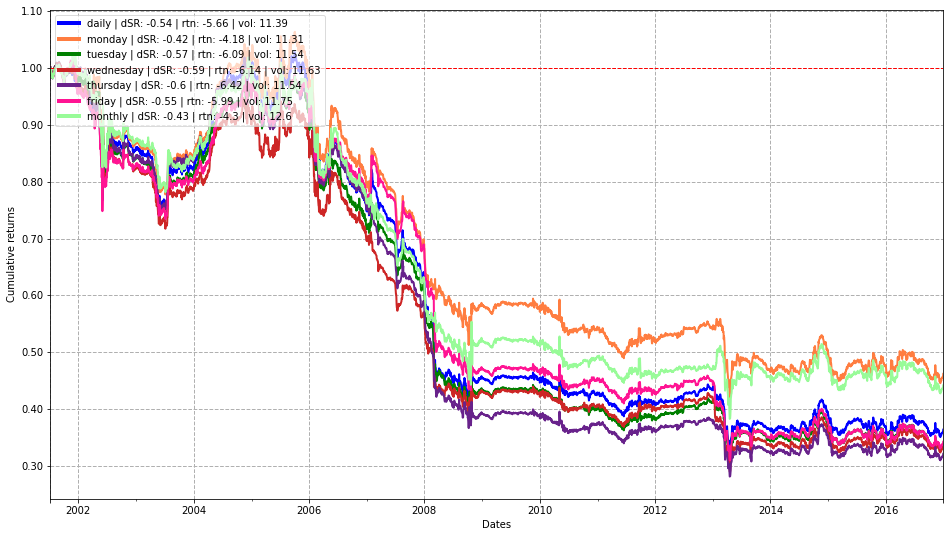

In [71]:
bts = [Backtest(signal = sig, 
               asset_returns = total_returns, 
               tcost = abs(total_returns*0), 
               settings = settings,
               settings_inject = {"rebalance_period":t}) for t in ["monday","tuesday", "wednesday",
                                                                   "thursday", "friday", "monthly"]]
for bt in bts:
  bt.run()
  
gen_plot_rtn(pd.concat([x.model_rtn.rename(x.rebalance_period) for x in [daily_bt]+bts], axis=1))

In [108]:
# pickle.dump(daily_bt, open("../BT/jpm_ppi_xs_asia_daily.p", "wb"))
# daily_bt = pickle.load(open("../BT/jpm_ppi_xs_asia_daily.p", "rb"))

# pickle.dump(bts[-1], open("../BT/jpm_ppi_xs_asia_monthly.p", "wb"))
# monthly_bt = pickle.load(open("../BT/jpm_ppi_xs_asia_monthly.p", "rb"))

# Regime Plot

In [ ]:
# sig = -1 * sig.pipe(omit_leading_na,"any").pipe(high_minus_low) 


# sig = asia_reer_cpi_cleaned.ffill().pct_change().pipe(zscore, 252*5, 252*3).apply(hold_until_flip) * -1
# sig = sig.pipe(demean_xs).pipe(top_bottom_xs)
# sig[abs(sig) < 0.25] = 0
# sig = CAP(sig, 2.5)